In [1]:
# Import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

In [2]:
# Set directory paths
train_dir = r"C:\Users\ayush\Desktop\gagan\gagan\Monday\DeepFire\DeepFire\Forest Fire Dataset\Training"
test_dir = r"C:\Users\ayush\Desktop\gagan\gagan\Monday\DeepFire\DeepFire\Forest Fire Dataset\Testing"

In [3]:
# Image parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 64

In [4]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    classes=['nofire', 'fire']  # Ensuring correct label order
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    classes=['nofire', 'fire']  # Ensuring correct label order
)

# Explicit class names (not relying on internal sorting)
class_names = ['nofire', 'fire']

Found 1216 images belonging to 2 classes.
Found 304 images belonging to 2 classes.


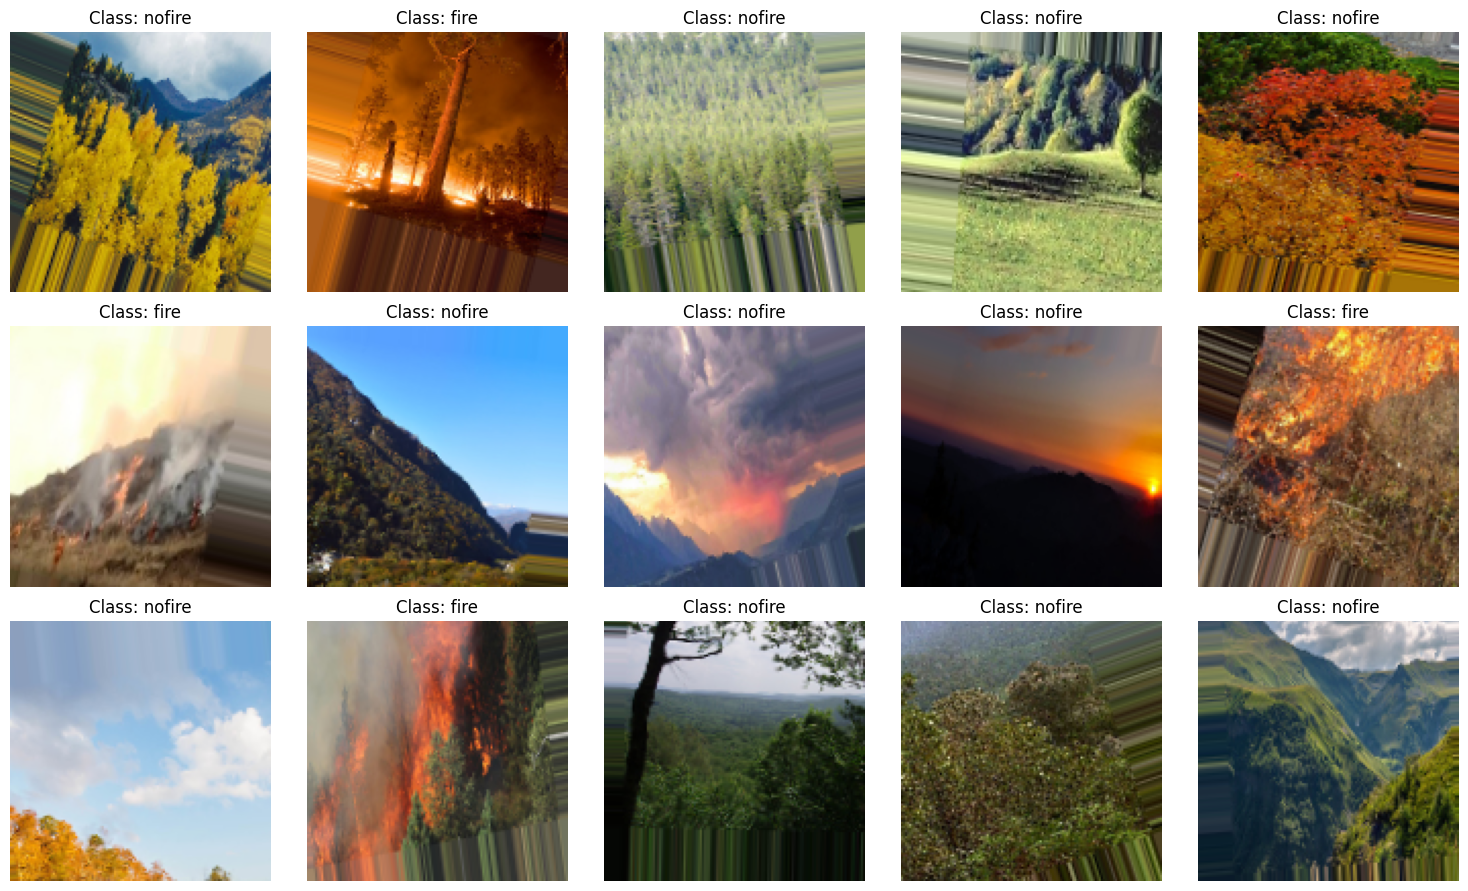

In [6]:
# Display random images to confirm correct class labeling
def display_random_images_from_generator(generator, class_names, num_images=15):
    images, labels = next(generator)
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    axes = axes.flatten()
    
    indices = random.sample(range(len(images)), num_images)
    
    for idx, ax in zip(indices, axes):
        ax.imshow(images[idx])
        ax.axis('off')
        label = class_names[int(labels[idx])]
        ax.set_title(f'Class: {label}')
    
    plt.tight_layout()
    plt.show()

# Display random images from the training set
display_random_images_from_generator(train_generator, class_names)

In [7]:
# Function to load test images and extract labels from filenames
def load_test_data(test_dir):
    images = []
    labels = []
    for filename in os.listdir(test_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            prefix = filename.split('_')[0].lower()
            label = 1 if prefix == 'fire' else 0
            img_path = os.path.join(test_dir, filename)
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load test data
test_images, test_labels = load_test_data(test_dir)

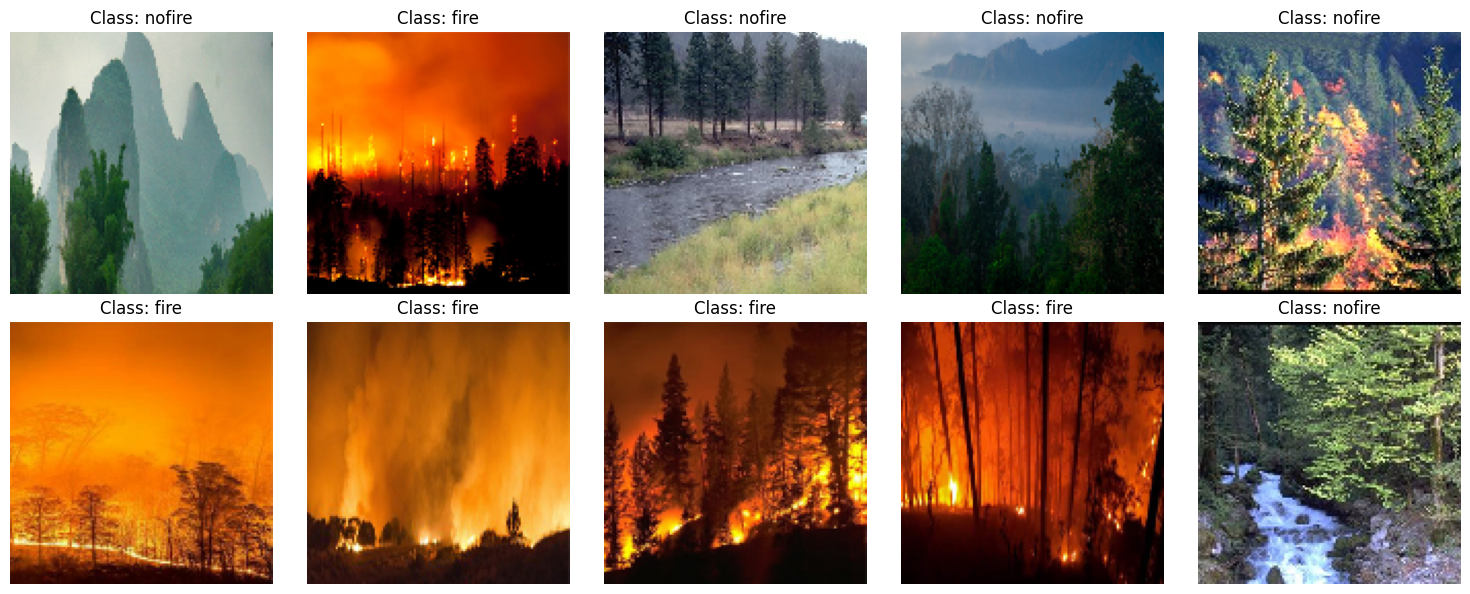

In [8]:
# Function to display random images in a 4x3 grid
def display_random_images(images, labels, class_names):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    indices = random.sample(range(len(images)), 12)
    
    for idx, ax in zip(indices, axes):
        ax.imshow(images[idx])
        ax.axis('off')
        label = class_names[labels[idx]]
        ax.set_title(f'Class: {label}')
    
    plt.tight_layout()
    plt.show()

# Class names for labels (assuming 0 = 'nofire', 1 = 'fire')
class_names = ['nofire', 'fire']

# Display random images from the test set
display_random_images(test_images, test_labels, class_names)

In [9]:
# Define MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Callbacks
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-6, monitor='val_loss', mode='min')
early_stop_cb = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[checkpoint_cb, reduce_lr_cb, early_stop_cb]
)

Epoch 1/25
19/19 [==============================] - 9s 272ms/step - loss: 0.6126 - accuracy: 0.7007 - val_loss: 0.3667 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 2/25
19/19 [==============================] - 5s 238ms/step - loss: 0.3439 - accuracy: 0.8520 - val_loss: 0.2346 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 3/25
19/19 [==============================] - 4s 234ms/step - loss: 0.2723 - accuracy: 0.8939 - val_loss: 0.1562 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 4/25
19/19 [==============================] - 4s 234ms/step - loss: 0.2176 - accuracy: 0.9153 - val_loss: 0.1534 - val_accuracy: 0.9539 - lr: 0.0010
Epoch 5/25
19/19 [==============================] - 4s 232ms/step - loss: 0.1874 - accuracy: 0.9326 - val_loss: 0.1269 - val_accuracy: 0.9605 - lr: 0.0010
Epoch 6/25
19/19 [==============================] - 4s 218ms/step - loss: 0.1748 - accuracy: 0.9334 - val_loss: 0.1484 - val_accuracy: 0.9474 - lr: 0.0010
Epoch 7/25
19/19 [==============================] - 4s 228ms/step - lo

In [11]:
# Evaluate the model on test data
model.load_weights("best_model.h5")
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

12/12 [==============================] - 1s 26ms/step - loss: 0.1102 - accuracy: 0.9684
Test Accuracy: 0.9684


12/12 [==============================] - 1s 11ms/step


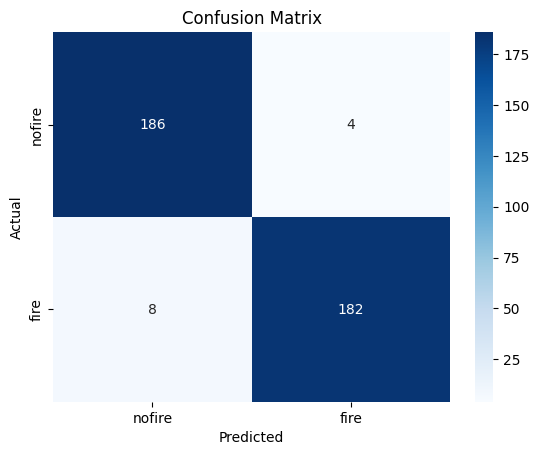

In [12]:
# Generate predictions
predictions = model.predict(test_images)
predicted_classes = (predictions > 0.5).astype(int)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nofire', 'fire'], yticklabels=['nofire', 'fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Extract confusion matrix values
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate evaluation metrics
prediction_accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
error_rate = (FP + FN) / (TP + TN + FP + FN)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Print the evaluation metrics
print(f"Prediction Accuracy: {prediction_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (TPR): {recall:.4f}")
print(f"Error Rate (ER): {error_rate:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Prediction Accuracy: 0.9684
Precision: 0.9785
Recall (TPR): 0.9579
Error Rate (ER): 0.0316
F1 Score: 0.9681


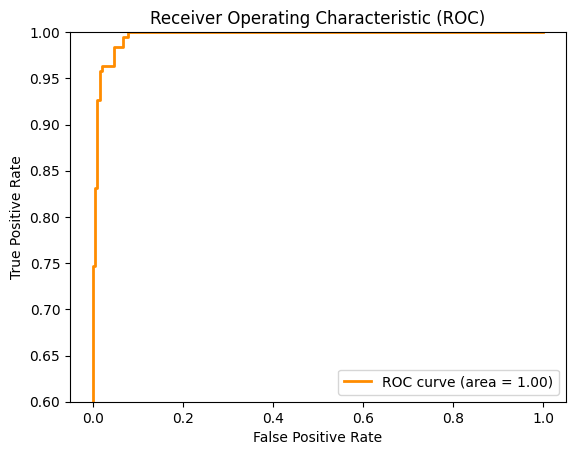

In [17]:
fpr, tpr, _ = roc_curve(test_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.ylim([0.6, 1.0])  # Zoom in on the True Positive Rate axis (0.8 to 1.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

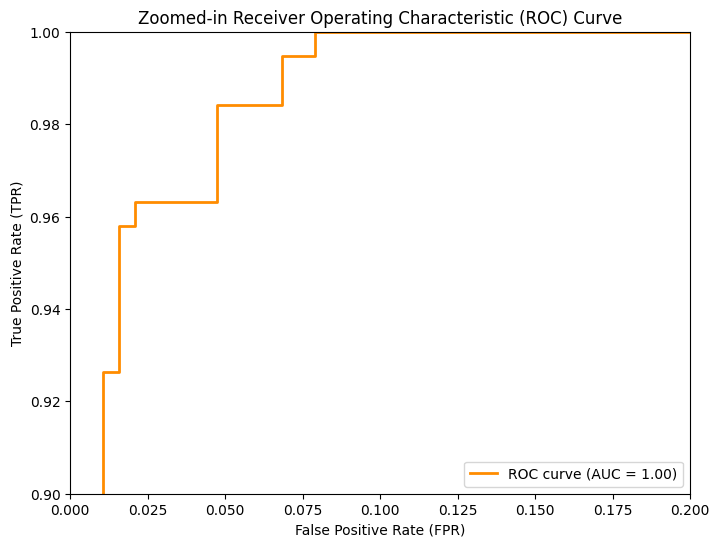

In [15]:
# Plot ROC curve (zoomed in at the top left)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.xlim([0.0, 0.2])  # Zoom in on the False Positive Rate axis (0 to 0.2)
plt.ylim([0.9, 1.0])  # Zoom in on the True Positive Rate axis (0.8 to 1.0)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Zoomed-in Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

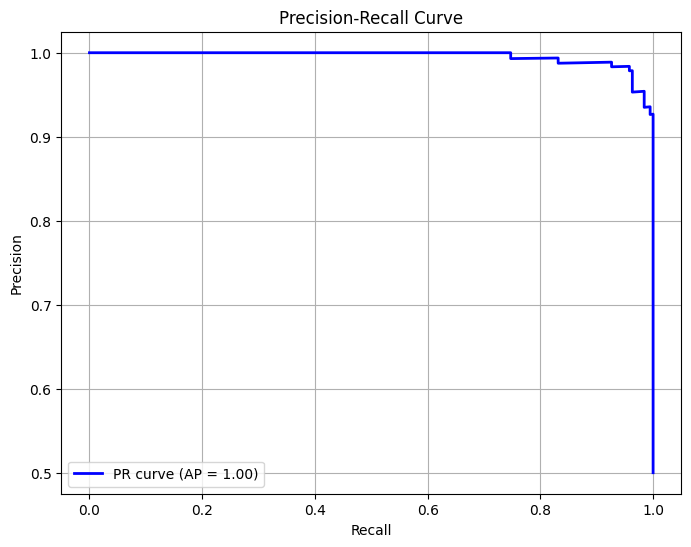

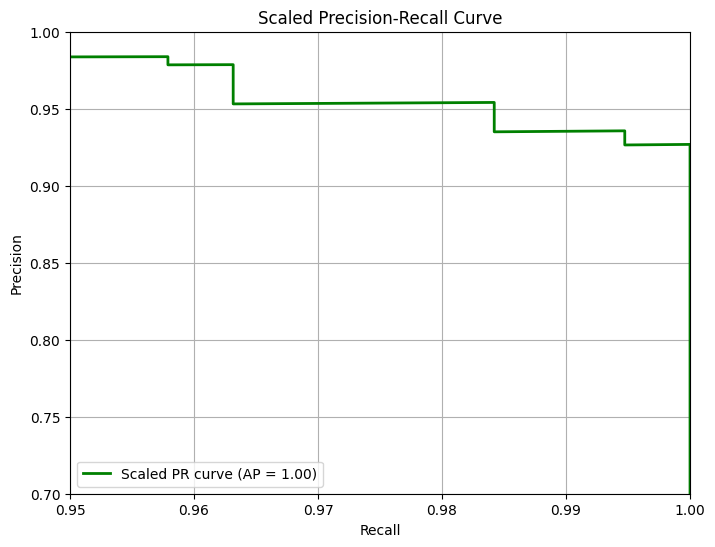

In [16]:
# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_labels, predictions)

# Calculate Average Precision Score (AP)
avg_precision = average_precision_score(test_labels, predictions)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Scaled Precision-Recall curve (focusing on precision and recall at higher values)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Scaled PR curve (AP = {avg_precision:.2f})')
plt.xlim([0.95, 1.0])  # Full recall axis
plt.ylim([0.7, 1.0])  # Full precision axis
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Scaled Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()